# Example with high-resolution CMIP6 models (~100 km) using Pangeo catalog 

### Time period

We will use data from 1985 to 2014.

### Variables 

| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
|  prsn         |    Snowfall Flux                        | [kg m-2 s-1]  | surface |
| clw           |    Mass Fraction of Cloud Liquid Water  |  [kg kg-1]    |    ml   |
| cli           |    Mass Fraction of Cloud Ice           | [kg kg-1]     |    ml   |
| tas           |    Near-Surface Air Temperature         |   [K]         | surface |
| ta            |    Air Temperature                      |  [K]          |    ml   |
| clivi         |    Ice Water Path                       | [kg m-2]      |         |
| lwp           |    Liquid Water Path                    | [kg m-2]      |         |


## Import python packages

In [23]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
import sys
sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils')
from imports import (xr, intake, cftime,  xe, glob, np, cm, pd, fct,ccrs, cy, plt,)

xr.set_options(display_style="html")

# %matplotlib inline


# reload imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Open CMIP6 online catalog

In [24]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,520279
dcpp_init_year,60


### Search correspnding data

In [25]:
# list_models = [
#     'NorESM2-MM', 
#     'TaiESM1',
#     'EC-Earth3-AerChem',
#     'GFDL-ESM4'
#     ]

list_models = [
    'NorESM2-MM',
    'TaiESM1',
    'EC-Earth3-AerChem',
    'GFDL-ESM4',
    'SAM0-UNICON',
    'CAMS-CSM1-0',
    'CAS-ESM2-0',
    'CMCC-CM2-HR4',
    'MPI-ESM1-2-HR',
    'BCC-CSM2-MR',
    'E3SM-1-1',
    'CMCC-CM2-SR5',
    'CMCC-ESM2',
    'FGOALS-f3-L',
    'E3SM-1-1-ECA',
    'CIESM',
    'GFDL-CM4',
    'MRI-ESM2-0']  

In [26]:
variable_id=[
            #  'prsn', 
            #  'clivi',
            'lwp',
            # 'tas'

             ]
cat = col.search(source_id=list_models, table_id = ['Amon', 'AERmon'], experiment_id=['historical'], variable_id=variable_id[0], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,AERmon,lwp,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
1,CMIP,NCC,NorESM2-MM,historical,r1i1p1f1,AERmon,lwp,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-MM/historica...,NaN,20191108
2,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,historical,r1i1p1f1,AERmon,lwp,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200624
3,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,AERmon,lwp,gn,gs://cmip6/CMIP6/CMIP/AS-RCEC/TaiESM1/historic...,NaN,20200630


In [27]:
cat.df['source_id'].unique()

array(['GFDL-ESM4', 'NorESM2-MM', 'EC-Earth3-AerChem', 'TaiESM1'],
      dtype=object)

### Create dictionary from the list of datasets we found

- This step may take several minutes so be patient!

In [28]:
# pass rename_cmip6 to consistently label coordinates
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )#preprocess=rename_cmip6)#'use_cftime':True})'decode_times':False


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [29]:
list(dset_dict.keys())

['CMIP.AS-RCEC.TaiESM1.historical.AERmon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.AERmon.gr',
 'CMIP.NCC.NorESM2-MM.historical.AERmon.gn',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.AERmon.gr1']

In [30]:
# show coordinates
for k, ds in dset_dict.items():
    print(k)
    print(list(ds.dims))

CMIP.AS-RCEC.TaiESM1.historical.AERmon.gn
['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.AERmon.gr
['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.NCC.NorESM2-MM.historical.AERmon.gn
['lat', 'bnds', 'lon', 'member_id', 'time']
CMIP.NOAA-GFDL.GFDL-ESM4.historical.AERmon.gr1
['bnds', 'lat', 'lon', 'member_id', 'time']


Double check the time axis. Are they having the same calendar?

In [31]:
# metadata of the historical run:
_d2 = pd.Series(["calendar",
                 "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
                 "parent_source_id",#"parent_sub_experiment_id", 
                 "parent_time_units",# "parent_variant_label"
                  ])
for i in dset_dict.keys():
    _data = []
    _names =[]
    _data.append(dset_dict[i].time.to_index().calendar)
    for k, v in dset_dict[i].attrs.items():
        
        if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
            _data.append(v)
            _names.append(k)
    _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)
    _d2.rename(columns={1:i.split('.')[2]}, inplace=True)
    _d2.rename(columns={0:i.split('.')[2]}, inplace=True)

_d2.dropna(how='all', axis=1, inplace=True)
_d2

,TaiESM1,TaiESM1,EC-Earth3-AerChem,NorESM2-MM,GFDL-ESM4
0,calendar,noleap,proleptic_gregorian,noleap,noleap
1,branch_time_in_parent,171550.0,0.0,438000.0,36500.0
2,parent_source_id,TaiESM1,EC-Earth3-AerChem,NorESM2-MM,GFDL-ESM4
3,parent_time_units,days since 1850-01-01,days since 1850-01-01,days since 0001-01-01,days since 0001-1-1


### Use data as xarray to make a simple plot

In [32]:
if variable_id[0] == 'lwp':
    ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn']
else:
    ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, member_id: 1, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    lwp        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 290, 192, 288), meta=np.ndarray>
Attributes: (12/54)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    ...                        ...
    tracking_id:               hdl:21.14100/f9b5958a-4435-41e0-8075-d71b586fc78b
    variable_id:               lwp
    variant_label:             r1i1p1f1
    version_id:                v20191108
    intake_esm_varname:        ['lwp']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-MM.historical.AERmon.gn

In [33]:
ds[variable_id[0]].attrs

{'cell_measures': 'area: areacella',
 'cell_methods': 'area: time: mean',
 'comment': 'The total mass of liquid water in cloud per unit area.',
 'history': "2019-11-25T21:59:50Z altered by CMOR: Converted units from 'kg/m2' to 'kg m-2'. 2019-11-25T21:59:51Z altered by CMOR: Converted type from 'd' to 'f'.",
 'long_name': 'Liquid Water Path',
 'original_name': 'TGCLDLWP',
 'original_units': 'kg/m2',
 'standard_name': 'atmosphere_mass_content_of_cloud_liquid_water',
 'units': 'kg m-2'}

In [34]:
_month = ds[variable_id[0]].groupby('time.month').mean('time', keep_attrs = True)
_jan  = _month.sel(month = 1)

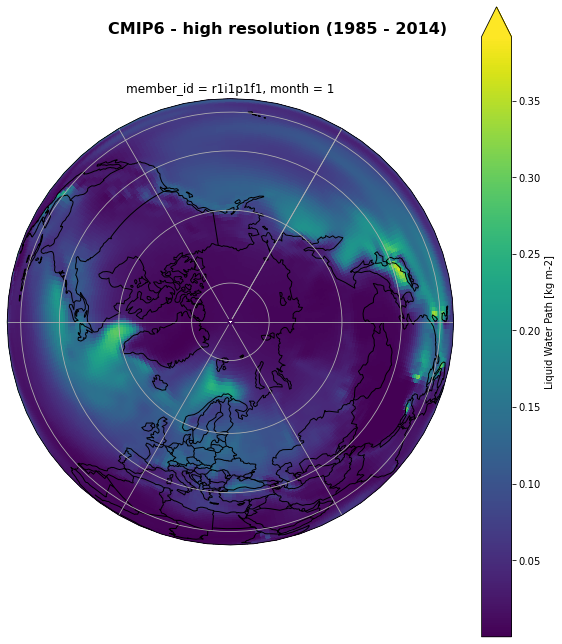

In [35]:
fig, ax = plt.subplots(1,1, 
                         figsize=[10,10], 
                         subplot_kw={'projection':ccrs.Orthographic(30, 90)})
fig.suptitle('CMIP6 - high resolution (1985 - 2014)', fontsize=16, fontweight="bold")

# Plot cosmetics 
ax.coastlines()
gl = ax.gridlines()
ax.add_feature(cy.feature.BORDERS);
gl.top_labels = False

im = _month.sel(month = 1).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar = True,extend = 'max')



plt.tight_layout()
fig.subplots_adjust(top=1)

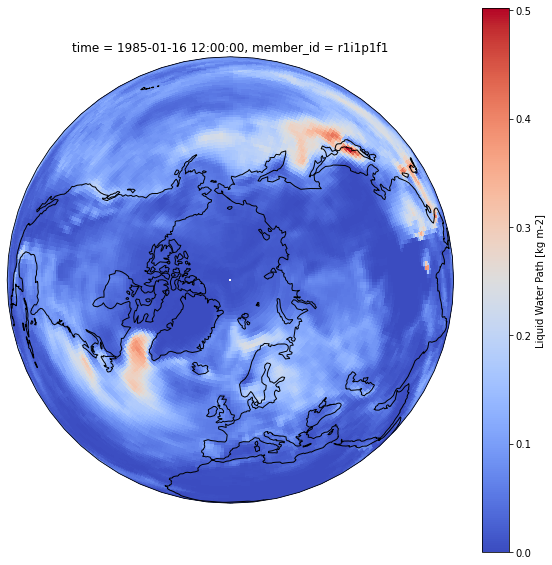

In [36]:
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()
ds[variable_id[0]].sel(time=cftime.DatetimeNoLeap(1985, 1, 16, 12, 0, 0, 0)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

### Get attributes (unique identifier)

In [37]:
ds.attrs['tracking_id']

'hdl:21.14100/f9b5958a-4435-41e0-8075-d71b586fc78b'

# Regrid CMIP6 data to common NorESM2-MM grid

In [38]:
starty = 1985; endy = 2014
year_range = range(starty, endy+1)

# create dictionary for reggridded data
ds_gridded_dict = dict()

# Read in the output grid from NorESM
if variable_id[0] == 'lwp':
    ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn'].isel(member_id = 0)
else:
    ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn'].isel(member_id = 0)
ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()

counter = 0




for keys in dset_dict.keys():
    # select only models which have atmospheric monthly values
    amon = keys.split('.')[-2]
    if amon == 'Amon' or amon == 'AERmon': 
        # select model name 
        model = keys.split('.')[2]
        
        # select where data should be saved
        filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
        savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/{}/'.format(model)
        nc_out = savepath + filename
        files = glob(nc_out)
        
        if nc_out in files:
        #     print('{} is downloaded'.format(nc_out))
        #     counter += 1
        #     print('Have regridded in total: {:} files'.format(str(counter)))
        # else:
            
            # Input data from CMIP6 model to be regridded
            ds_in = dset_dict[keys].isel(member_id = 0)
            ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()
            
            # common time grid
            ds_in['time'] = ds_out['time']
            
            
            
            # Regrid data
            ds_in_regrid = fct.regrid_data(ds_in, ds_out)
            
            # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
            ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
            ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)
            

            
            # create dataset with all models
            ds_gridded_dict[model] = ds_in_regrid
            # ds_in_regrid.close(); ds_in.close(); ds_out.close()
            
            # Save to netcdf file
            ds_in_regrid.to_netcdf(nc_out)
            print('file written: {}'.format(nc_out))

Overwrite existing file: bilinear_192x288_192x288.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable lwp as the horizontal dimensions for this dataset.
lwp True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/TaiESM1/lwp_Amon_1deg_198501_201412.nc
Overwrite existing file: bilinear_256x512_192x288.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable lwp as the horizontal dimensions for this dataset.
lwp True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/EC-Earth3-AerChem/lwp_Amon_1deg_198501_201412.nc
Overwrite existing file: bilinear_192x288_192x288.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable lwp as the horizontal dimensions for this dataset.
lwp True
file written: /scratch/franzihe/output/CMIP6_hist/1deg/NorESM2-MM/lwp_Amon_1deg_198501_201412.nc
Overwrite existing file: bilinear_180x288_

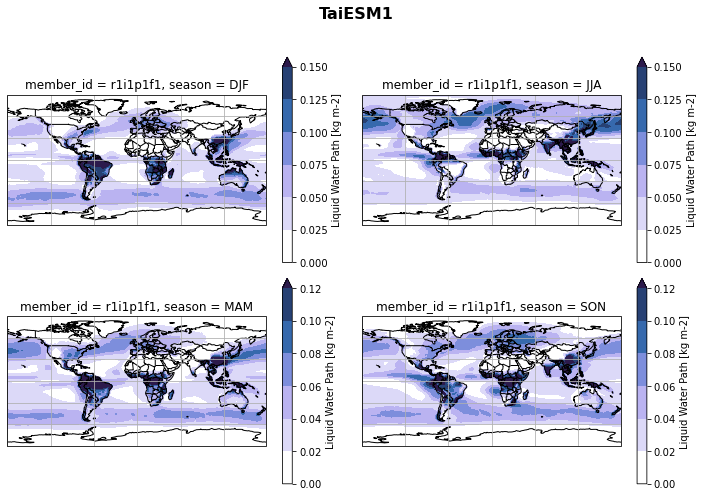

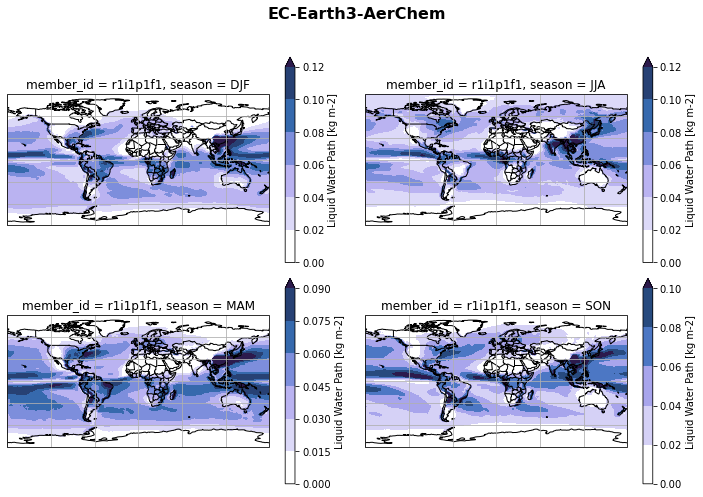

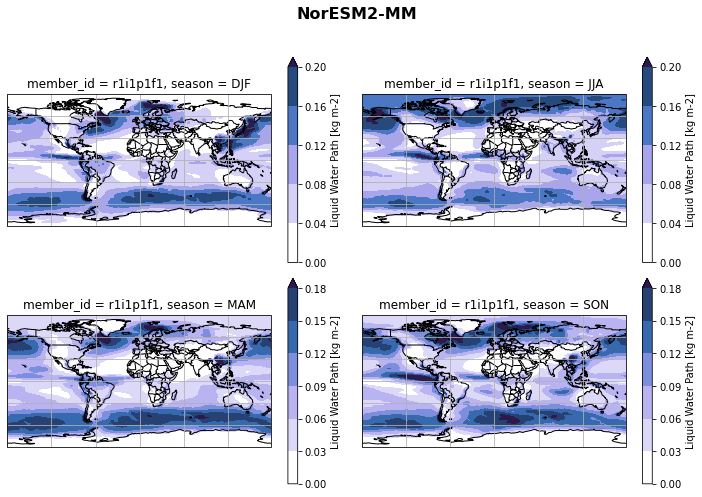

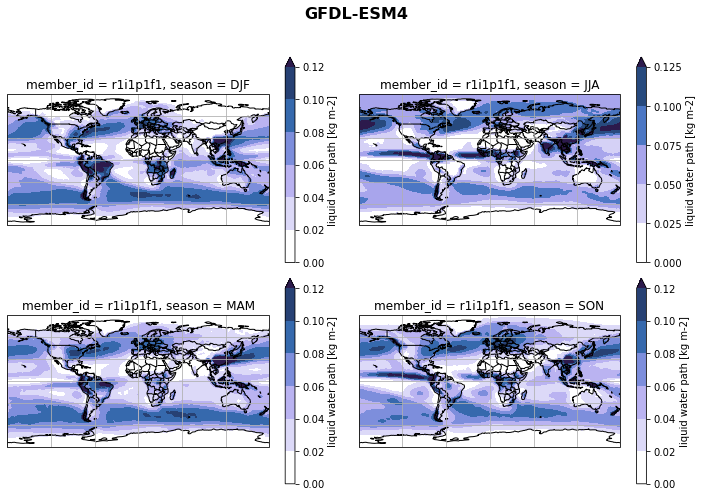

In [39]:
for model in ds_gridded_dict.keys():
    _smean = ds_gridded_dict[model][variable_id[0]].groupby('time.season').mean('time', keep_attrs=True)

    fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(model, fontsize=16, fontweight="bold")
    axs = axsm.flatten()

    for ax, i in zip(axs, _smean.season):
        if variable_id[0] == 'prsn':
            # plot seasonal mean and convert kg m-2 s-1 to mm/day
            (_smean.sel(season = i)*86400).plot.contourf(ax=ax, 
                                        transform=ccrs.PlateCarree(),
                                        cmap=cm.devon_r, 
                                        robust=True)
        else:
            (_smean.sel(season = i)).plot.contourf(ax=ax, 
                                        transform=ccrs.PlateCarree(),
                                        cmap=cm.devon_r, 
                                        robust=True)

        ax.coastlines()
        gl = ax.gridlines()
        ax.add_feature(cy.feature.BORDERS);
        gl.top_labels = False

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

In [40]:
ds_gridded_dict.keys()

dict_keys(['TaiESM1', 'EC-Earth3-AerChem', 'NorESM2-MM', 'GFDL-ESM4'])

# Connect all models into one Dataset with new coordinate 'model'

In [41]:
_ds = list(ds_gridded_dict.values())
_coord = list(ds_gridded_dict.keys())
ds_prsn_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
ds_prsn_cmip = ds_prsn_cmip.drop('bnds')

# savet to netcdf
filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/'
nc_out = savepath + filename
files = glob(nc_out)

counter = 0 
# Save to netcdf file
if nc_out in files:
    print('{} is downloaded'.format(nc_out))
    counter += 1
    print('Have saved in total: {:} files'.format(str(counter)))
else:
    ds_prsn_cmip.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))

/scratch/franzihe/output/CMIP6_hist/1deg/lwp_Amon_1deg_198501_201412.nc is downloaded
Have saved in total: 1 files


# Create model and seasonal mean of all regridded models

In [42]:
prsn = ds_prsn_cmip.mean('model', keep_attrs=True, skipna = True).groupby('time.season').mean('time', keep_attrs=True, skipna = True)

# savet to netcdf
filename = '{}_season_1deg_{}_{}.nc'.format(variable_id[0], starty, endy)
nc_out = savepath + filename
files = glob(nc_out)

counter = 0 
# Save to netcdf file
if nc_out in files:
    print('{} is downloaded'.format(nc_out))
    counter += 1
    print('Have saved in total: {:} files'.format(str(counter)))
else:
    prsn.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))



# calculate seasonal spread
prsn_std = ds_prsn_cmip.mean('model', keep_attrs=True, skipna = True).groupby('time.season').std('time', keep_attrs=True, skipna = True)

/scratch/franzihe/output/CMIP6_hist/1deg/lwp_season_1deg_1985_2014.nc is downloaded
Have saved in total: 1 files


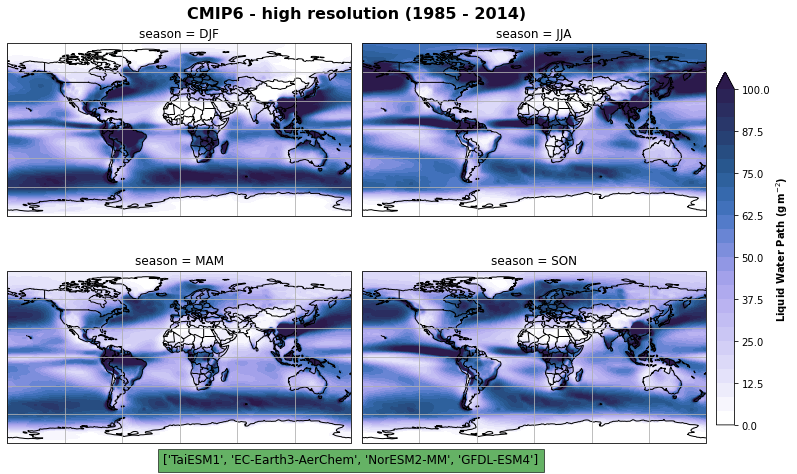

In [43]:
# only mean of variable

fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
fig.suptitle('CMIP6 - high resolution (1985 - 2014)', fontsize=16, fontweight="bold")

axs = axsm.flatten()
for ax, i in zip(axs, prsn.season):
    if variable_id[0] == 'prsn':
        im = (prsn[variable_id[0]].sel(season = i)*86400).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.devon_r,
                                     robust=True,
                                     vmin = 0, vmax=2.5, 
                                     levels = 25,
                                     add_colorbar = False,
                                     extend = 'max')
        
    elif variable_id[0] == 'clivi' or variable_id[0] == 'lwp':
        im = (prsn[variable_id[0]].sel(season = i)*1000).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.devon_r,
                                     robust=True,
                                     vmin = 0, vmax=100, 
                                     levels = 25,
                                     add_colorbar = False,
                                     extend = 'max')
        
    elif variable_id[0] == 'tas':
        im = prsn[variable_id[0]].sel(season = i).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.vik,
                                     robust=True,
                                     vmin = 246 , vmax=300, 
                                     levels = 40,
                                     add_colorbar = False,
                                     extend = 'both')
        


    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl.top_labels = False

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)





if variable_id[0] == 'prsn':
    cb.set_label(label='MEAN - Snowfall (mm$\,$day$^{-1}$)', weight='bold') 
elif variable_id[0] == 'clivi':
    cb.set_label(label='Ice Water Path (g$\,$m$^{-2}$)', weight='bold')
elif variable_id[0] == 'lwp':
    cb.set_label(label='Liquid Water Path (g$\,$m$^{-2}$)', weight='bold')
elif variable_id[0] == 'tas':
    cb.set_label(label='2-m temperature (K)', weight='bold')




plt.tight_layout()
fig.subplots_adjust(top=1)



axs[2].text(1,-0.12, list(ds_gridded_dict.keys())[0:5], size=12, ha="center", 
         transform=axs[2].transAxes, bbox ={'facecolor':'green',
                'alpha':0.6,
                'pad':5})
if len(list(ds_gridded_dict.keys())) > 4:
    axs[2].text(1,-0.25, list(ds_gridded_dict.keys())[5:10], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
if len(list(ds_gridded_dict.keys())) > 10:
    axs[2].text(1,-0.38, list(ds_gridded_dict.keys())[10:-1], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_mean_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)


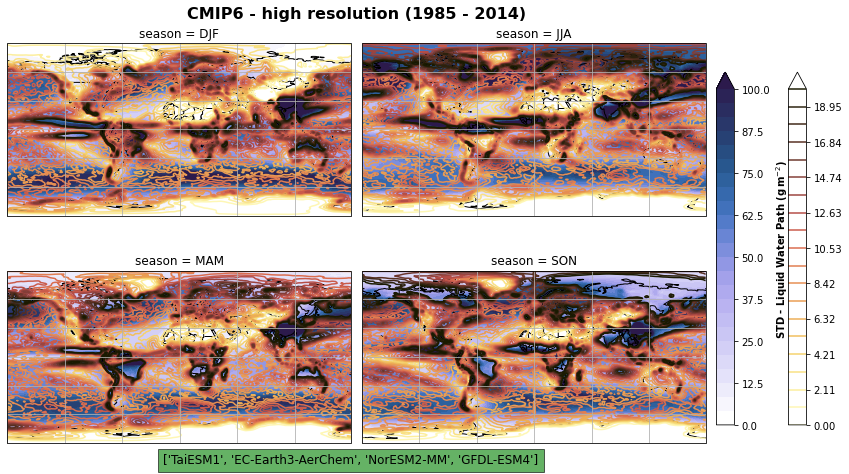

In [45]:
# mean and std of variable
fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
fig.suptitle('CMIP6 - high resolution (1985 - 2014)', fontsize=16, fontweight="bold")

axs = axsm.flatten()
for ax, i in zip(axs, prsn.season):
    if variable_id[0] == 'prsn':
        im = (prsn[variable_id[0]].sel(season = i)*86400).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.devon_r,
                                     robust=True,
                                     vmin = 0, vmax=2.5, 
                                     levels = 25,
                                     add_colorbar = False,
                                     extend = 'max')
        sm = (prsn_std[variable_id[0]].sel(season = i)*86400).plot.contour(ax = ax, 
                                                                      transform=ccrs.PlateCarree(), 
                                                                      robust=True,
                                                                      vmin = 0, vmax = 0.6,
                                                                      levels = 10,
                                                                      cmap=cm.lajolla,
                                                                      add_colorbar=False)
    elif variable_id[0] == 'clivi' or variable_id[0] == 'lwp':
        im = (prsn[variable_id[0]].sel(season = i)*1000).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.devon_r,
                                     robust=True,
                                     vmin = 0, vmax=100, 
                                     levels = 25,
                                     add_colorbar = False,
                                     extend = 'max')
        sm = (prsn_std[variable_id[0]].sel(season = i)*1000).plot.contour(ax = ax, 
                                                                      transform=ccrs.PlateCarree(), 
                                                                      robust=True,
                                                                      vmin = 0, vmax = 20,
                                                                      levels = 20, 
                                                                      cmap=cm.lajolla,
                                                                      add_colorbar=False)
    elif variable_id[0] == 'tas':
        im = prsn[variable_id[0]].sel(season = i).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.vik,
                                     robust=True,
                                     vmin = 246 , vmax=300, 
                                     levels = 40,
                                     add_colorbar = False,
                                     extend = 'both')
        (prsn_std[variable_id[0]].sel(season = i)).plot.contour(ax = ax, 
                                                                      transform=ccrs.PlateCarree(), 
                                                                      robust=True,
                                                                    #   vmin = 0, vmax = 0.6,
                                                                    #   levels = 10, 
                                                                      cmap=cm.lajolla,
                                                                      add_colorbar=True)


    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl.top_labels = False

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)

cbar_ax = fig.add_axes([1.10, 0.15, 0.025, 0.7])
sb = fig.colorbar(sm, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)



if variable_id[0] == 'prsn':
    cb.set_label(label='MEAN - Snowfall (mm$\,$day$^{-1}$)', weight='bold') 
    sb.set_label(label='STD - Snowfall (mm$\,$day$^{-1}$)', weight='bold')
elif variable_id[0] == 'clivi':
    cb.set_label(label='MEAN - Ice Water Path (g$\,$m$^{-2}$)', weight='bold')
    sb.set_label(label='STD - Ice Water Path (g$\,$m$^{-2}$)', weight='bold')
elif variable_id[0] == 'lwp':
    cb.set_label(label='MEAN - Liquid Water Path (g$\,$m$^{-2}$)', weight='bold')
    cb.set_label(label='STD - Liquid Water Path (g$\,$m$^{-2}$)', weight='bold')
elif variable_id[0] == 'tas':
    cb.set_label(label='2-m temperature (K)', weight='bold')




plt.tight_layout()
fig.subplots_adjust(top=1)



axs[2].text(1,-0.12, list(ds_gridded_dict.keys())[0:5], size=12, ha="center", 
         transform=axs[2].transAxes, bbox ={'facecolor':'green',
                'alpha':0.6,
                'pad':5})
if len(list(ds_gridded_dict.keys())) > 4:
    axs[2].text(1,-0.25, list(ds_gridded_dict.keys())[5:10], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
if len(list(ds_gridded_dict.keys())) > 10:
    axs[2].text(1,-0.38, list(ds_gridded_dict.keys())[10:-1], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_mean_std_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)
